# DPU example: MNIST Classifier
----

## Aim/s

This notebook shows how to deploy Convolutional Neural Network (CNN)
model for hand-written digit recognition. The network was trained on
the MNIST dataset,quantized using Vitis AI compiler tools, and
deployed on the DPU.

Compared to the other notebooks delivered in this folder, this notebook
shows how to deploy a **user-trained** DPU model on PYNQ image; i.e.,
the model used in this notebook does not come from the model zoo.

## References

* [Train your own DPU models](https://github.com/Xilinx/DPU-PYNQ/tree/master/host#train-your-own-dpu-models-from-scratch)
* [Vitis AI model zoo](https://github.com/Xilinx/Vitis-AI/tree/master/models/AI-Model-Zoo)

## Last revised
* Mar 8, 2021
    * Initial revision
----

## 1. Prepare the overlay
We will download the overlay onto the board. 

In [2]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

In [3]:
overlay.load_model("xmodels/CGNet_avmax.xmodel")

Let's import some libraries as well. The `mnist` package
requires some additional headers for URL requests.

In [4]:
import time
import torch
import torchvision
import torch.nn as nn 
import torch.nn.functional as F
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

/usr/local/share/pynq-venv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/usr/local/share/pynq-venv/lib/python3.8/site-packages/torchvision/models/detection/anchor_utils.py:63: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xe (Triggered internally at  /root/pytorch/torch/csrc/utils/tensor_numpy.cpp:68.)
  device: torch.device = torch.device("cpu"),


## 2. Load test data

The `mnist` package enables the following data for users:

* `test_images()`: returns test images stored as a numpy array. 
Each image is a grayscale 28x28 pixels, representing a digit between 0 and 9.
* `test_labels()`: returns a list of the true labels stored as numpy array.


There are 2 pre-processing steps we need to do to the test images 
before we can use it:

1. The raw numpy array delivered by `mnist` has a data type of 
uint8 (data ranges from 0 to 255); we need to normalize the elements to 
floating-point numbers ranging from 0 to 1.
2. The VART API will expect each input sample to have 3 dimensions; 
so we need to expand the original numpy array.

In [7]:
image_dir = 'DanishTeamData/img/'
mask_dir = 'DanishTeamData/mask/'

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, mask_suffix='', transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.mask_suffix = mask_suffix

        if transform == None:
          self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        else: 
          self.transform = transform
        self.ids = [os.path.splitext(file)[0] for file in os.listdir(image_dir)
                        if not file.startswith('.') and not '20210305' in file]

    def __getitem__(self, i):
        basename = self.ids[i]

        mask_file = glob(self.mask_dir + basename + self.mask_suffix + '.*')
        img_file = glob(self.image_dir + basename + '.*')

        mask = cv2.imread(mask_file[0])
        img = cv2.imread(img_file[0]) 

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        img = img * (1/255)
        
#         img = self.transform(img)
#         mask = self.transform(mask)
        base_array = np.zeros_like(mask)#[1, mask.shape[0], mask.shape[1]])
        base_array[mask > 0.5] = 1  
#         base_array = base_array.reshape(1, base_array.shape[0], base_array.shape[1])

        return img, base_array

    def __len__(self):
        return len(self.ids)

dataset = CustomDataset(image_dir, mask_dir)
dataset[0][0].shape

(1088, 1456, 3)

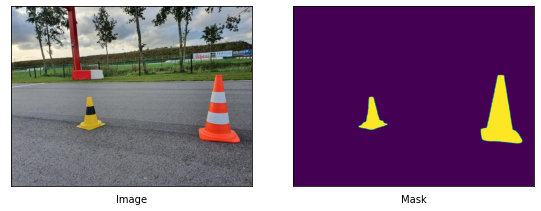

In [9]:
import matplotlib.pyplot as plt

def plot_class_masks(item: np.ndarray) -> None:
    """Plot a particular view of the true vs predicted segmentation.

    This function separates each class into its own image and
    does not perform any thresholding.

    Parameters:
        y_true: True segmentation (image_shape, num_classes).
        y_predicted: Predicted segmentation (image_shape, num_classes).
            If y_predicted is not provided, only the true values are displayed.
    """
    num_rows = 1

    num_columns = 2
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 4, num_rows * 4))
    axes = axes.reshape(-1, num_columns)
    plt.tight_layout()
    
    axes[0, 0].imshow(item[0])
    axes[0, 0].set_xlabel("Image")
    axes[0, 0].axes.set_xticks([])
    axes[0, 0].axes.set_yticks([])
    axes[0, 1].imshow(item[1].squeeze())
    axes[0, 1].set_xlabel("Mask")
    axes[0, 1].axes.set_xticks([])
    axes[0, 1].axes.set_yticks([])

    plt.show()

plot_class_masks(dataset[10])

In [10]:
def display_pred_mask(output, image, mask, output_name='outname.png'):
    num_rows = 1
    num_columns = 3
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns*4, num_rows*4))
    axes = axes.reshape(-1, num_columns)
    plt.tight_layout()
    
    axes[0, 0].imshow(image)
    axes[0, 0].set_label("Image")
    axes[0, 0].axes.set_xticks([])
    axes[0, 0].axes.set_yticks([])
    axes[0, 1].imshow(mask)
    axes[0, 1].set_label("Mask")
    axes[0, 1].axes.set_xticks([])
    axes[0, 1].axes.set_yticks([])
    
    output = np.array(output.tolist())
    base_array = np.zeros_like(output)
    base_array[output > 0.3] = 1
    
    axes[0, 2].imshow(base_array.squeeze())
    axes[0, 2].set_label("Pred Mask")
    axes[0, 2].axes.set_xticks([])
    axes[0, 2].axes.set_yticks([])
    
    plt.savefig(output_name)

## 3. Use VART
Now we should be able to use VART API to do the task.

In [11]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

softmax = np.empty(outputSize)

We can define a few buffers to store input and output data.
They will be reused during multiple runs.

In [12]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]
image.shape

(1, 1088, 1456, 3)

We will also define a few functions to calculate softmax.

In [13]:
class CGNetHead(nn.Module):
    def __init__(self):
        super(CGNetHead, self).__init__()
#         self.size = torch.Size([1088, 1456])
        self.size = torch.Size([544, 728])
        
    def forward(self, x):
        out = F.interpolate(x, self.size, mode='bilinear', align_corners=True)
        out = torch.sigmoid(out)
        
        return out
    
model_head = CGNetHead()

## 4. Run DPU to make predictions

We can now classify a couple of digit pictures. For each picture, 
the classification result (shown as 'Prediction') is displayed on top of 
the picture. 

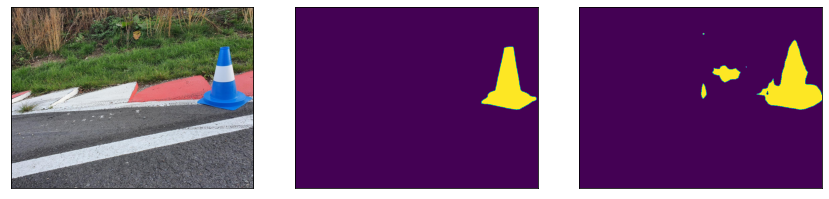

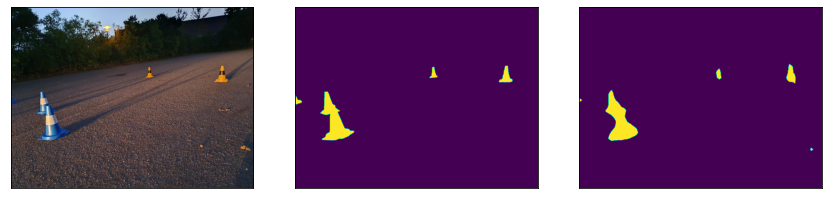

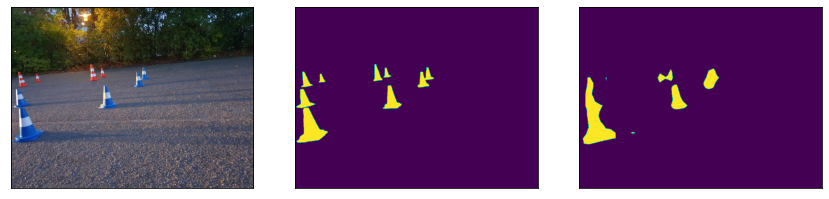

In [17]:
num_pics  = 3
for i in range(num_pics):
    img, mask = dataset[i]
    image[0,...] = img
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    out = torch.tensor(output_data[0].tolist()).permute(0, 3, 1, 2)
    out = model_head(out)
    display_pred_mask(out, img, mask, output_name='output1.png')

In [ ]:
num_pics  = 20
e = 20
times = np.zeros([num_pics*e])
times_head = np.zeros([num_pics*e])
idx = 0
for _ in range(e):
    for i in range(num_pics):
        img, mask = dataset[i%e]
        image[0,...] = img
        then = time.time()
        job_id = dpu.execute_async(input_data, output_data)
        dpu.wait(job_id)
        diff = time.time() - then
        times[idx] = diff
        out = torch.tensor(output_data[0].tolist()).permute(0, 3, 1, 2)
        out = model_head(out)
        diff = time.time() - then
        times_head[idx] = diff
        idx += 1
    
print("Classification time : ", np.mean(times))
print("Classification time w/ head : ", np.mean(times_head))

In [13]:
def make_binary(array):
    base_array = np.zeros_like(array)
    base_array[array > 0.5] = 1

    return base_array

In [14]:
num_pics  = 20
e = 20
accuracy = np.zeros([num_pics*e])
idx = 0
for _ in range(e):
    for i in range(num_pics):
        img, mask = dataset[i%e]
        image[0,...] = img
        job_id = dpu.execute_async(input_data, output_data)
        dpu.wait(job_id)
        out = torch.tensor(output_data[0].tolist()).permute(0, 3, 1, 2)
        out = model_head(out)
        
        out = make_binary(np.array(out[0].tolist()))
        mask = make_binary(mask)

        intersection = np.logical_and(out[0], mask)
        union = np.logical_or(out[0], mask)
    
        iou = np.sum(intersection).item() / np.sum(union).item() if np.sum(union).item() > 0 else 1
        accuracy[idx] = iou
                
        idx += 1

print("Classification accuracy : ", np.mean(accuracy))

Classification accuracy :  0.7193622009956155


In [20]:
np.mean(accuracy)

0.1633443852936074

We can also evaluate on the entire test dataset.

## 5. Clean up

We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

In [14]:
del overlay
del dpu

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----